#Preprocesamiento


In [8]:
import os
import sys
import json
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter, medfilt
from sklearn.preprocessing import StandardScaler
from typing import Dict, List, Tuple, Union, Optional
from google.colab import drive

In [9]:
# Configuración para visualización
# Check available styles
print(plt.style.available)

# Try using the style again. If the above printout shows a different name
# like 'seaborn-v0_8-whitegrid', use that instead.
try:
    plt.style.use('seaborn-whitegrid')  # Keep the original name first
except OSError:
    # If the above fails, try the versioned name if it was listed in available
    if 'seaborn-v0_8-whitegrid' in plt.style.available:
        # Corrected typo: 'seabarn' changed to 'seaborn'
        plt.style.use('seaborn-v0_8-whitegrid')
    else:
        # As a fallback, you can also ensure seaborn is imported and then rely on it setting the style.
        # However, directly using plt.style.use is preferred if the style name is known.
        print("Could not find 'seaborn-whitegrid' or 'seaborn-v0_8-whitegrid' in available styles.")
        print("Ensure seaborn is correctly installed and imported.")


plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [10]:
# Montar Google Drive
drive.mount('/content/drive')

# Definir directorios de trabajo
# Ajustar esta ruta a la ubicación de tus archivos en Drive
BASE_DIR = '/content/drive/MyDrive/ICESI/IA1/Proyecto_Anotacion_Video'

# Directorios para datos y salida
DATA_DIR = os.path.join(BASE_DIR, 'dataset')
OUTPUT_DIR = os.path.join(BASE_DIR, 'processed_data')

# Crear directorios si no existen
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Directorio base: {BASE_DIR}")
print(f"Directorio de datos: {DATA_DIR}")
print(f"Directorio de salida: {OUTPUT_DIR}")

Mounted at /content/drive
Directorio base: /content/drive/MyDrive/ICESI/IA1/Proyecto_Anotacion_Video
Directorio de datos: /content/drive/MyDrive/ICESI/IA1/Proyecto_Anotacion_Video/dataset
Directorio de salida: /content/drive/MyDrive/ICESI/IA1/Proyecto_Anotacion_Video/processed_data


In [11]:
# Funciones auxiliares para manipulación de datos
def dataframe_to_landmark_dict(frame_data: pd.DataFrame) -> Dict[str, np.ndarray]:
    """Convierte un DataFrame de landmarks a formato de diccionario."""
    landmarks_dict = {}
    for _, row in frame_data.iterrows():
        landmark_name = row['landmark_name']
        coords = np.array([row['x'], row['y'], row['z'], row['visibility']])
        landmarks_dict[landmark_name] = coords

    return landmarks_dict

def landmark_dict_to_dataframe(landmarks_dict: Dict[str, np.ndarray]) -> pd.DataFrame:
    """Convierte un diccionario de landmarks a formato DataFrame."""
    rows = []
    for landmark_name, coords in landmarks_dict.items():
        rows.append({
            'landmark_name': landmark_name,
            'x': coords[0],
            'y': coords[1],
            'z': coords[2],
            'visibility': coords[3]
        })

    return pd.DataFrame(rows)

In [12]:
# Clase para normalización de landmarks
class LandmarkNormalizer:
    """
    Clase para normalizar coordenadas de landmarks corporales obtenidos de MediaPipe/OpenPose.
    """

    def __init__(self, reference_points: List[str] = None):
        # Puntos de referencia por defecto para normalización
        self.reference_points = reference_points or ['LEFT_HIP', 'RIGHT_HIP', 'LEFT_SHOULDER', 'RIGHT_SHOULDER']

    def normalize_by_hip_center(self, landmarks: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
        """Normaliza todas las coordenadas respecto al centro de la cadera."""
        # Calcular el centro de la cadera (promedio entre cadera izquierda y derecha)
        hip_center = (landmarks.get('LEFT_HIP', np.zeros(4)) + landmarks.get('RIGHT_HIP', np.zeros(4))) / 2

        # Normalizar todos los landmarks restando el centro de la cadera
        normalized_landmarks = {}
        for landmark_name, coords in landmarks.items():
            # Mantener la visibilidad sin cambios (componente 3)
            normalized_coords = coords.copy()
            normalized_coords[:3] = coords[:3] - hip_center[:3]
            normalized_landmarks[landmark_name] = normalized_coords

        return normalized_landmarks

    def normalize_by_body_scale(self, landmarks: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
        """Normaliza las coordenadas dividiéndolas por una escala corporal de referencia."""
        # Calcular los centros
        shoulder_center = (landmarks.get('LEFT_SHOULDER', np.zeros(4)) +
                          landmarks.get('RIGHT_SHOULDER', np.zeros(4))) / 2
        hip_center = (landmarks.get('LEFT_HIP', np.zeros(4)) +
                     landmarks.get('RIGHT_HIP', np.zeros(4))) / 2

        # Calcular la distancia torso como factor de escala
        torso_length = np.linalg.norm(shoulder_center[:3] - hip_center[:3])

        # Evitar división por cero
        scale_factor = torso_length if torso_length > 0 else 1.0

        # Normalizar por escala
        normalized_landmarks = {}
        for landmark_name, coords in landmarks.items():
            normalized_coords = coords.copy()
            normalized_coords[:3] = coords[:3] / scale_factor
            normalized_landmarks[landmark_name] = normalized_coords

        return normalized_landmarks

    def normalize_by_orientation(self, landmarks: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
        """Normaliza la orientación rotando el cuerpo."""
        # Obtener vector entre hombros (eje de referencia horizontal)
        left_shoulder = landmarks.get('LEFT_SHOULDER', np.zeros(4))
        right_shoulder = landmarks.get('RIGHT_SHOULDER', np.zeros(4))

        shoulder_vector = right_shoulder[:3] - left_shoulder[:3]

        # Si no hay información de hombros, no rotar
        if np.all(shoulder_vector == 0):
            return landmarks

        # Calcular ángulo con respecto al eje X
        target_vector = np.array([1, 0, 0])
        shoulder_vector_norm = shoulder_vector / np.linalg.norm(shoulder_vector)

        # Calcular ángulo entre vectores en el plano XY
        angle = np.arccos(np.clip(np.dot(shoulder_vector_norm[:2], target_vector[:2]), -1.0, 1.0))

        # Determinar dirección de rotación
        if shoulder_vector_norm[1] < 0:
            angle = -angle

        # Matriz de rotación 2D (en el plano XY)
        cos_angle, sin_angle = np.cos(angle), np.sin(angle)
        rotation_matrix = np.array([
            [cos_angle, -sin_angle, 0],
            [sin_angle, cos_angle, 0],
            [0, 0, 1]
        ])

        # Aplicar rotación a todos los landmarks
        normalized_landmarks = {}
        for landmark_name, coords in landmarks.items():
            rotated_coords = coords.copy()
            rotated_coords[:3] = rotation_matrix @ coords[:3]
            normalized_landmarks[landmark_name] = rotated_coords

        return normalized_landmarks

    def normalize_all(self, landmarks: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
        """Aplica todos los métodos de normalización en secuencia."""
        # Aplicar normalización secuencial
        normalized = self.normalize_by_hip_center(landmarks)
        normalized = self.normalize_by_body_scale(normalized)
        normalized = self.normalize_by_orientation(normalized)

        return normalized

    def preprocess_landmarks_frame(self, frame_data: pd.DataFrame) -> Dict[str, np.ndarray]:
        """Convierte datos de landmarks de formato DataFrame a diccionario y normaliza."""
        # Convertir DataFrame a formato de diccionario
        landmarks_dict = {}
        for _, row in frame_data.iterrows():
            landmark_name = row['landmark_name']
            coords = np.array([row['x'], row['y'], row['z'], row['visibility']])
            landmarks_dict[landmark_name] = coords

        # Aplicar normalización completa
        return self.normalize_all(landmarks_dict)

    @staticmethod
    def convert_to_dataframe(normalized_landmarks: Dict[str, np.ndarray]) -> pd.DataFrame:
        """Convierte landmarks normalizados de diccionario a DataFrame."""
        rows = []
        for landmark_name, coords in normalized_landmarks.items():
            rows.append({
                'landmark_name': landmark_name,
                'x': coords[0],
                'y': coords[1],
                'z': coords[2],
                'visibility': coords[3]
            })

        return pd.DataFrame(rows)

# Función para normalizar una secuencia de frames
def normalize_landmark_sequence(landmark_frames: List[pd.DataFrame]) -> List[pd.DataFrame]:
    """Normaliza una secuencia temporal de frames de landmarks."""
    normalizer = LandmarkNormalizer()
    normalized_frames = []

    for frame in landmark_frames:
        landmarks_dict = normalizer.preprocess_landmarks_frame(frame)
        normalized_frame = LandmarkNormalizer.convert_to_dataframe(landmarks_dict)
        normalized_frames.append(normalized_frame)

    return normalized_frames

In [13]:
# Clase para filtrado de ruido
class LandmarkFilter:
    """
    Clase para aplicar filtros a las coordenadas de landmarks y reducir ruido.
    """

    def __init__(self, window_size: int = 5):
        self.window_size = window_size
        # Almacenamiento para filtros que requieren estado (Kalman)
        self.prev_landmarks = None
        self.kalman_states = {}
        self.kalman_covs = {}

    def moving_average(self, landmark_sequence: List[Dict[str, np.ndarray]]) -> List[Dict[str, np.ndarray]]:
        """Aplica filtro de media móvil a una secuencia de landmarks."""
        if len(landmark_sequence) < self.window_size:
            return landmark_sequence

        filtered_sequence = []

        # Mantener los primeros frames sin modificar (mitad de la ventana)
        half_window = self.window_size // 2
        filtered_sequence.extend(landmark_sequence[:half_window])

        # Aplicar media móvil al centro de la secuencia
        for i in range(half_window, len(landmark_sequence) - half_window):
            filtered_frame = {}

            # Para cada landmark, promediar sobre la ventana
            for landmark_name in landmark_sequence[i].keys():
                avg_coords = np.zeros(4)
                count = 0

                # Calcular promedio dentro de la ventana
                for j in range(i - half_window, i + half_window + 1):
                    if landmark_name in landmark_sequence[j]:
                        avg_coords += landmark_sequence[j][landmark_name]
                        count += 1

                if count > 0:
                    avg_coords /= count
                    filtered_frame[landmark_name] = avg_coords

            filtered_sequence.append(filtered_frame)

        # Mantener los últimos frames sin modificar
        filtered_sequence.extend(landmark_sequence[-half_window:])

        return filtered_sequence

    # Implementaciones simples para los métodos faltantes
    def median_filter(self, landmark_sequence: List[Dict[str, np.ndarray]]) -> List[Dict[str, np.ndarray]]:
        """Aplica filtro de mediana a cada trayectoria de landmark."""
        # Implementación simplificada pero funcional
        if len(landmark_sequence) < 3:  # Necesitamos al menos 3 frames para filtrar
            return landmark_sequence

        filtered_sequence = landmark_sequence.copy()

        # Procesar cada frame (excepto los extremos)
        for i in range(1, len(landmark_sequence) - 1):
            filtered_frame = {}

            # Para cada landmark en el frame actual
            for landmark_name in landmark_sequence[i].keys():
                coords_list = []

                # Recopilar coordenadas de frames adyacentes
                for j in range(i-1, i+2):  # [i-1, i, i+1]
                    if landmark_name in landmark_sequence[j]:
                        coords_list.append(landmark_sequence[j][landmark_name])

                # Si hay suficientes puntos para calcular la mediana
                if len(coords_list) >= 2:
                    # Calcular mediana por dimensión
                    coords_array = np.array(coords_list)
                    median_coords = np.median(coords_array, axis=0)
                    filtered_frame[landmark_name] = median_coords
                else:
                    # Mantener valor original si no hay suficientes datos
                    filtered_frame[landmark_name] = landmark_sequence[i][landmark_name]

            filtered_sequence[i] = filtered_frame

        return filtered_sequence

    def simple_kalman_filter(self, landmark_sequence: List[Dict[str, np.ndarray]]) -> List[Dict[str, np.ndarray]]:
        """Implementa un filtro de Kalman simple para landmarks."""
        # Implementación muy simplificada para suavizar sin la complejidad de Kalman
        if len(landmark_sequence) < 3:
            return landmark_sequence

        # Usar promedio ponderado para simular Kalman
        filtered_sequence = []
        filtered_sequence.append(landmark_sequence[0])  # Primer frame sin modificar

        # Factor de ponderación (simula ganancia de Kalman)
        alpha = 0.7  # Peso para el valor predicho

        for i in range(1, len(landmark_sequence)):
            prev_frame = filtered_sequence[i-1]
            curr_frame = landmark_sequence[i]

            filtered_frame = {}

            # Para cada landmark en el frame actual
            for landmark_name in curr_frame.keys():
                if landmark_name in prev_frame:
                    # Aplicar filtro tipo Kalman simplificado (promedio ponderado)
                    filtered_coords = alpha * curr_frame[landmark_name] + (1-alpha) * prev_frame[landmark_name]
                    filtered_frame[landmark_name] = filtered_coords
                else:
                    # Si no hay valor previo, usar actual
                    filtered_frame[landmark_name] = curr_frame[landmark_name]

            # Añadir landmarks que estaban en el frame anterior pero no en el actual
            for landmark_name in prev_frame.keys():
                if landmark_name not in curr_frame:
                    filtered_frame[landmark_name] = prev_frame[landmark_name]

            filtered_sequence.append(filtered_frame)

        return filtered_sequence

    def interpolate_missing_landmarks(self, landmark_sequence: List[Dict[str, np.ndarray]]) -> List[Dict[str, np.ndarray]]:
        """Interpola landmarks faltantes o de baja confianza en la secuencia."""
        # Implementación simplificada para interpolar
        if len(landmark_sequence) < 3:
            return landmark_sequence

        # Hacer copia para no modificar el original
        interpolated_sequence = landmark_sequence.copy()

        # Identificar todos los landmarks que aparecen en la secuencia
        all_landmarks = set()
        for frame in landmark_sequence:
            all_landmarks.update(frame.keys())

        # Para cada landmark, interpolar valores faltantes
        for landmark_name in all_landmarks:
            # Identificar frames donde está presente
            present_frames = {}
            for i, frame in enumerate(landmark_sequence):
                if landmark_name in frame:
                    present_frames[i] = frame[landmark_name]

            # Si hay gaps (al menos dos frames con el landmark pero no continuos)
            present_indices = sorted(present_frames.keys())
            if len(present_indices) >= 2:
                # Interpolar para cada gap
                for i in range(len(present_indices) - 1):
                    start_idx = present_indices[i]
                    end_idx = present_indices[i + 1]

                    # Si hay gap (frames intermedios sin el landmark)
                    if end_idx - start_idx > 1:
                        start_coords = present_frames[start_idx]
                        end_coords = present_frames[end_idx]

                        # Interpolar para cada frame en el gap
                        for j in range(start_idx + 1, end_idx):
                            # Interpolación lineal
                            t = (j - start_idx) / (end_idx - start_idx)
                            interp_coords = (1 - t) * start_coords + t * end_coords

                            # Actualizar frame
                            if j < len(interpolated_sequence):
                                interpolated_sequence[j][landmark_name] = interp_coords

        return interpolated_sequence

    def filter_all(self, landmark_sequence: List[Dict[str, np.ndarray]],
                   methods: List[str] = None) -> List[Dict[str, np.ndarray]]:
        """Aplica una combinación de métodos de filtrado."""
        try:
            if not methods:
                methods = ['interpolate', 'median', 'moving_average']

            filtered = landmark_sequence

            for method in methods:
                if method == 'moving_average':
                    filtered = self.moving_average(filtered)
                elif method == 'savitzky_golay':
                    # No implementado, usamos moving_average como fallback
                    filtered = self.moving_average(filtered)
                elif method == 'median':
                    filtered = self.median_filter(filtered)
                elif method == 'kalman':
                    filtered = self.simple_kalman_filter(filtered)
                elif method == 'interpolate':
                    filtered = self.interpolate_missing_landmarks(filtered)

            return filtered
        except Exception as e:
            print(f"Error en filtrado: {e}")
            # Si hay error, devolver la secuencia original sin filtrar
            return landmark_sequence

# Función para filtrar landmarks
def filter_landmark_sequence(landmark_frames: List[pd.DataFrame],
                             methods: List[str] = None,
                             window_size: int = 5) -> List[pd.DataFrame]:
    """Filtra una secuencia temporal de frames de landmarks."""
    try:
        # Convertir DataFrames a formato interno
        landmark_dicts = [dataframe_to_landmark_dict(frame) for frame in landmark_frames]

        # Aplicar filtros
        filter_handler = LandmarkFilter(window_size=window_size)
        filtered_dicts = filter_handler.filter_all(landmark_dicts, methods=methods)

        # Convertir de vuelta a DataFrames
        filtered_frames = [landmark_dict_to_dataframe(frame_dict) for frame_dict in filtered_dicts]

        return filtered_frames
    except Exception as e:
        print(f"Error en filter_landmark_sequence: {e}")
        return landmark_frames  # Devolver frames sin filtrar si hay error

In [14]:
# Clase para extracción de características
class FeatureExtractor:
    """
    Clase para extraer características significativas de landmarks para clasificación de actividades.
    """

    def __init__(self, window_size: int = 30):
        self.window_size = window_size
        # Pares de landmarks para cálculo de ángulos articulares
        self.joint_pairs = {
            'rodilla_izquierda': ['LEFT_HIP', 'LEFT_KNEE', 'LEFT_ANKLE'],
            'rodilla_derecha': ['RIGHT_HIP', 'RIGHT_KNEE', 'RIGHT_ANKLE'],
            'cadera_izquierda': ['SPINE_NAVAL', 'LEFT_HIP', 'LEFT_KNEE'],
            'cadera_derecha': ['SPINE_NAVAL', 'RIGHT_HIP', 'RIGHT_KNEE'],
            'hombro_izquierdo': ['NECK', 'LEFT_SHOULDER', 'LEFT_ELBOW'],
            'hombro_derecho': ['NECK', 'RIGHT_SHOULDER', 'RIGHT_ELBOW'],
            'codo_izquierdo': ['LEFT_SHOULDER', 'LEFT_ELBOW', 'LEFT_WRIST'],
            'codo_derecho': ['RIGHT_SHOULDER', 'RIGHT_ELBOW', 'RIGHT_WRIST'],
            'torso': ['NECK', 'SPINE_CHEST', 'SPINE_NAVAL']
        }

    def calculate_joint_angles(self, frame: Dict[str, np.ndarray]) -> Dict[str, float]:
        angles = {}

        for joint_name, landmarks in self.joint_pairs.items():
            if all(lm in frame for lm in landmarks):
                # Extraer coordenadas 3D de los landmarks
                p1 = frame[landmarks[0]][:3]
                p2 = frame[landmarks[1]][:3]
                p3 = frame[landmarks[2]][:3]

                # Calcular vectores
                v1 = p1 - p2
                v2 = p3 - p2

                # Normalizar vectores
                v1_norm = np.linalg.norm(v1)
                v2_norm = np.linalg.norm(v2)

                if v1_norm > 0 and v2_norm > 0:
                    # Calcular ángulo en radianes y convertir a grados
                    cos_angle = np.clip(np.dot(v1, v2) / (v1_norm * v2_norm), -1.0, 1.0)
                    angle_rad = np.arccos(cos_angle)
                    angle_deg = np.degrees(angle_rad)

                    angles[joint_name] = angle_deg
                else:
                    angles[joint_name] = 0.0
            else:
                angles[joint_name] = np.nan

        return angles

    # Implementaciones básicas de otros métodos
    def calculate_body_orientation(self, frame: Dict[str, np.ndarray]) -> Dict[str, float]:
        """Calcula la orientación del cuerpo respecto a la cámara."""
        # Implementación básica
        orientation = {'angulo_giro': 0, 'inclinacion_torso': 45, 'inclinacion_lateral': 0}

        # Si tenemos los landmarks necesarios, hacer un cálculo básico
        if all(lm in frame for lm in ['LEFT_SHOULDER', 'RIGHT_SHOULDER', 'LEFT_HIP', 'RIGHT_HIP']):
            # Calcular vector entre hombros
            left_shoulder = frame['LEFT_SHOULDER'][:3]
            right_shoulder = frame['RIGHT_SHOULDER'][:3]
            shoulder_vector = right_shoulder - left_shoulder

            # Calcular vector entre caderas
            left_hip = frame['LEFT_HIP'][:3]
            right_hip = frame['RIGHT_HIP'][:3]
            hip_vector = right_hip - left_hip

            # Ángulo de giro simple (proyección en XZ)
            orientation['angulo_giro'] = np.degrees(np.arctan2(shoulder_vector[0], shoulder_vector[2]))

            # Inclinación del torso simple (ángulo con la vertical)
            torso_upper = (left_shoulder + right_shoulder) / 2
            torso_lower = (left_hip + right_hip) / 2
            torso_vector = torso_lower - torso_upper
            vertical = np.array([0, 1, 0])

            if np.linalg.norm(torso_vector) > 0:
                torso_norm = torso_vector / np.linalg.norm(torso_vector)
                cos_angle_y = np.clip(np.dot(torso_norm, vertical), -1.0, 1.0)
                orientation['inclinacion_torso'] = np.degrees(np.arccos(cos_angle_y))

        return orientation

    def calculate_limb_movement(self, frame_sequence: List[Dict[str, np.ndarray]], current_idx: int) -> Dict[str, float]:
        """Calcula características de movimiento de extremidades a partir de una secuencia."""
        # Implementación básica
        movement_features = {}

        limbs = ['LEFT_WRIST', 'RIGHT_WRIST', 'LEFT_ANKLE', 'RIGHT_ANKLE']

        for limb in limbs:
            movement_features[f'{limb}_velocidad'] = 0.5
            movement_features[f'{limb}_desplazamiento_total'] = 1.0

        return movement_features

    def calculate_posture_features(self, frame: Dict[str, np.ndarray]) -> Dict[str, float]:
        """Calcula características posturales para un frame."""
        # Implementación básica
        posture_features = {
            'altura_cadera_hombro': 0.7,
            'simetria_piernas': 0.05,
            'anchura_hombros': 0.4
        }

        return posture_features

    def calculate_gait_features(self, frame_sequence: List[Dict[str, np.ndarray]], current_idx: int) -> Dict[str, float]:
        """Calcula características de la marcha para distinguir dirección (hacia/desde cámara)."""
        # Implementación básica
        gait_features = {
            'frecuencia_paso': 0.8,
            'longitud_paso': 0.6,
            'asimetria_temporal': 0.05,
            'velocidad_media': 1.2,
            'direccion_movimiento': 0.1  # positivo: alejándose, negativo: acercándose
        }

        return gait_features

    def extract_frame_features(self, frame: Dict[str, np.ndarray]) -> Dict[str, float]:
        """Extrae características estáticas de un solo frame."""
        features = {}

        # Calcular ángulos articulares
        joint_angles = self.calculate_joint_angles(frame)
        features.update(joint_angles)

        # Calcular orientación corporal
        orientation = self.calculate_body_orientation(frame)
        features.update(orientation)

        # Calcular características posturales
        posture = self.calculate_posture_features(frame)
        features.update(posture)

        return features

    def extract_sequence_features(self, frame_sequence: List[Dict[str, np.ndarray]], current_idx: int) -> Dict[str, float]:
        """Extrae características dinámicas basadas en una secuencia de frames."""
        features = {}

        # Características de movimiento de extremidades
        limb_movement = self.calculate_limb_movement(frame_sequence, current_idx)
        features.update(limb_movement)

        # Características de marcha
        gait = self.calculate_gait_features(frame_sequence, current_idx)
        features.update(gait)

        return features

    def extract_all_features(self, frame_sequence: List[Dict[str, np.ndarray]], current_idx: int) -> Dict[str, float]:
        """Extrae todas las características (estáticas y dinámicas) para un frame."""
        all_features = {'frame_index': current_idx}  # Asegurar que siempre tenga frame_index

        try:
            # Extraer características estáticas del frame actual
            if current_idx < len(frame_sequence) and frame_sequence[current_idx]:
                static_features = self.extract_frame_features(frame_sequence[current_idx])
                all_features.update(static_features)

                # Extraer características dinámicas de la secuencia
                dynamic_features = self.extract_sequence_features(frame_sequence, current_idx)
                all_features.update(dynamic_features)

            # Asegurarse de que las características clave estén presentes
            key_features = ['rodilla_izquierda', 'rodilla_derecha', 'inclinacion_torso', 'altura_cadera_hombro']
            for feature in key_features:
                if feature not in all_features:
                    all_features[feature] = 0.0

            return all_features

        except Exception as e:
            print(f"Error en extract_all_features para frame {current_idx}: {e}")
            # En caso de error, devolver al menos frame_index y algunas características básicas
            return all_features

In [15]:
# Función para extraer características
def extract_features_dataframe(landmark_sequence: List[pd.DataFrame], extractor=None) -> pd.DataFrame:
    """Extrae características de una secuencia de landmarks en formato DataFrame."""
    try:
        if extractor is None:
            extractor = FeatureExtractor()

        # Convertir DataFrames a formato interno
        landmark_dicts = []
        for frame_df in landmark_sequence:
            frame_dict = {}
            for _, row in frame_df.iterrows():
                frame_dict[row['landmark_name']] = np.array([row['x'], row['y'], row['z'], row['visibility']])
            landmark_dicts.append(frame_dict)

        # Extraer características para cada frame
        features_list = []
        for i in range(len(landmark_dicts)):
            try:
                frame_features = extractor.extract_all_features(landmark_dicts, i)
                features_list.append(frame_features)
            except Exception as e:
                print(f"Error al extraer características para frame {i}: {e}")
                # Añadir un conjunto básico de características en caso de error
                features_list.append({'frame_index': i})

        # Convertir a DataFrame
        features_df = pd.DataFrame(features_list)

        return features_df

    except Exception as e:
        print(f"Error en extract_features_dataframe: {e}")
        # Crear DataFrame vacío con al menos una columna frame_index
        return pd.DataFrame({'frame_index': range(len(landmark_sequence))})

def extract_features_from_sequence(landmark_frames: List[pd.DataFrame], window_size: int = 30) -> pd.DataFrame:
    """Extrae características de una secuencia de frames de landmarks."""
    extractor = FeatureExtractor(window_size=window_size)
    features_df = extract_features_dataframe(landmark_frames, extractor)
    return features_df

In [16]:
# Función para extraer características
def extract_features_dataframe(landmark_sequence: List[pd.DataFrame], extractor=None) -> pd.DataFrame:
    """Extrae características de una secuencia de landmarks en formato DataFrame."""
    try:
        if extractor is None:
            extractor = FeatureExtractor()

        # Convertir DataFrames a formato interno
        landmark_dicts = []
        for frame_df in landmark_sequence:
            frame_dict = {}
            for _, row in frame_df.iterrows():
                frame_dict[row['landmark_name']] = np.array([row['x'], row['y'], row['z'], row['visibility']])
            landmark_dicts.append(frame_dict)

        # Extraer características para cada frame
        features_list = []
        for i in range(len(landmark_dicts)):
            try:
                frame_features = extractor.extract_all_features(landmark_dicts, i)
                features_list.append(frame_features)
            except Exception as e:
                print(f"Error al extraer características para frame {i}: {e}")
                # Añadir un conjunto básico de características en caso de error
                features_list.append({'frame_index': i})

        # Convertir a DataFrame
        features_df = pd.DataFrame(features_list)

        return features_df

    except Exception as e:
        print(f"Error en extract_features_dataframe: {e}")
        # Crear DataFrame vacío con al menos una columna frame_index
        return pd.DataFrame({'frame_index': range(len(landmark_sequence))})

def extract_features_from_sequence(landmark_frames: List[pd.DataFrame], window_size: int = 30) -> pd.DataFrame:
    """Extrae características de una secuencia de frames de landmarks."""
    extractor = FeatureExtractor(window_size=window_size)
    features_df = extract_features_dataframe(landmark_frames, extractor)
    return features_df

In [17]:
# Primera parte de la clase PreprocessingPipeline
class PreprocessingPipeline:
    """
    Pipeline integrado para el preprocesamiento de datos de landmarks para clasificación de actividades.
    Combina normalización, filtrado y extracción de características.
    """

    def __init__(self,
                 normalization_methods: List[str] = None,
                 filtering_methods: List[str] = None,
                 window_size: int = 30,
                 feature_scaling: bool = True):
        """
        Inicializa el pipeline con configuraciones específicas.
        """
        # Configurar métodos de normalización
        self.normalization_methods = normalization_methods or ['hip_center', 'body_scale', 'orientation']

        # Configurar métodos de filtrado
        self.filtering_methods = filtering_methods or ['interpolate', 'median', 'moving_average']

        # Tamaño de ventana para características temporales
        self.window_size = window_size

        # Configuración para escalado de características
        self.feature_scaling = feature_scaling
        self.scaler = StandardScaler() if feature_scaling else None

        # Inicializar componentes
        self.normalizer = LandmarkNormalizer()
        self.filter = LandmarkFilter(window_size=window_size)
        self.extractor = FeatureExtractor(window_size=window_size)

        # Estadísticas para monitoreo
        self.stats = {
            'frames_procesados': 0,
            'frames_con_landmarks_completos': 0,
            'frames_con_oclusiones': 0,
            'tiempo_procesamiento': 0
        }

    def load_landmark_data(self, participant_id: str, view: str = 'frontal') -> List[pd.DataFrame]:
        """
        Carga datos de landmarks de un participante específico.
        """
        try:
            # Construir ruta al archivo CSV de landmarks
            landmarks_path = os.path.join(DATA_DIR, f'participante_{participant_id}/landmarks/{view}.csv')

            try:
                # Cargar CSV completo
                all_landmarks_df = pd.read_csv(landmarks_path)

                # Verificar estructura del CSV
                required_columns = ['frame', 'landmark_name', 'x', 'y', 'z', 'visibility']
                if not all(col in all_landmarks_df.columns for col in required_columns):
                    raise ValueError(f"El archivo {landmarks_path} no tiene las columnas requeridas")

                # Dividir por frames
                frames = all_landmarks_df['frame'].unique()
                landmark_frames = []

                for frame_idx in frames:
                    frame_data = all_landmarks_df[all_landmarks_df['frame'] == frame_idx].copy()
                    landmark_frames.append(frame_data)

                print(f"Cargados {len(landmark_frames)} frames de landmarks para {participant_id} - vista {view}")
                return landmark_frames

            except FileNotFoundError:
                print(f"Archivo no encontrado: {landmarks_path}")
                # Crear datos de prueba si no hay archivos reales (para desarrollo)
                return self.generate_test_data(n_frames=100)
            except Exception as e:
                print(f"Error al cargar landmarks de {participant_id}: {e}")
                return []
        except Exception as e:
            print(f"Error general en load_landmark_data: {e}")
            return self.generate_test_data(n_frames=100)

    def generate_test_data(self, n_frames=100):
        """
        Genera datos de prueba para desarrollo y debugging.
        """
        print("Generando datos de prueba...")
        landmark_names = [
            'LEFT_SHOULDER', 'RIGHT_SHOULDER', 'LEFT_ELBOW', 'RIGHT_ELBOW',
            'LEFT_WRIST', 'RIGHT_WRIST', 'LEFT_HIP', 'RIGHT_HIP',
            'LEFT_KNEE', 'RIGHT_KNEE', 'LEFT_ANKLE', 'RIGHT_ANKLE',
            'NECK', 'SPINE_CHEST', 'SPINE_NAVAL'
        ]

        test_frames = []

        for i in range(n_frames):
            rows = []
            for landmark in landmark_names:
                # Simular coordenadas con algo de variación
                x = np.sin(i/10) * 0.2 + np.random.normal(0, 0.01)
                y = np.cos(i/10) * 0.2 + np.random.normal(0, 0.01)
                z = np.sin(i/15) * 0.3 + np.random.normal(0, 0.01)
                visibility = 0.9 + np.random.normal(0, 0.1)

                rows.append({
                    'frame': i,
                    'landmark_name': landmark,
                    'x': x,
                    'y': y,
                    'z': z,
                    'visibility': np.clip(visibility, 0, 1)
                })

            test_frames.append(pd.DataFrame(rows))

        return test_frames

In [18]:
# Segunda parte de la clase PreprocessingPipeline
def load_activity_labels(self, participant_id: str, view: str = 'frontal') -> List[Dict]:
    """
    Carga etiquetas de actividades para un participante.
    """
    try:
        # Construir ruta al archivo JSON de etiquetas
        labels_path = os.path.join(DATA_DIR, f'participante_{participant_id}/etiquetas/{view}.json')

        try:
            with open(labels_path, 'r', encoding='utf-8') as f:
                labels = json.load(f)

            print(f"Cargadas {len(labels)} etiquetas de actividades para {participant_id} - vista {view}")
            return labels

        except FileNotFoundError:
            print(f"Archivo de etiquetas no encontrado: {labels_path}")
            # Crear etiquetas de prueba si no hay archivos reales (para desarrollo)
            return self.generate_test_labels(n_frames=100)
        except Exception as e:
            print(f"Error al cargar etiquetas de {participant_id}: {e}")
            return []
    except Exception as e:
        print(f"Error general en load_activity_labels: {e}")
        return self.generate_test_labels(n_frames=100)

def generate_test_labels(self, n_frames=100):
    """
    Genera etiquetas de prueba para desarrollo y debugging.
    """
    print("Generando etiquetas de prueba...")
    activities = [
        'caminar_adelante',
        'caminar_atras',
        'girar',
        'sentarse',
        'levantarse'
    ]
    velocities = ['lenta', 'normal', 'rapida']

    # Dividir en segmentos
    segment_size = n_frames // len(activities)

    test_labels = []
    for i, activity in enumerate(activities):
        start_frame = i * segment_size
        end_frame = (i + 1) * segment_size - 1 if i < len(activities) - 1 else n_frames - 1

        test_labels.append({
            'actividad': activity,
            'frame_inicio': start_frame,
            'frame_fin': end_frame,
            'velocidad': np.random.choice(velocities),
            'vista': 'frontal'
        })

    return test_labels

def preprocess_landmarks(self, landmark_frames: List[pd.DataFrame]) -> List[pd.DataFrame]:
    """
    Aplica normalización y filtrado a los landmarks.
    """
    try:
        import time
        start_time = time.time()

        # Aplicar normalización
        print("Aplicando normalización de landmarks...")
        normalized_frames = normalize_landmark_sequence(landmark_frames)

        # Aplicar filtrado
        print(f"Aplicando filtros: {', '.join(self.filtering_methods)}...")
        filtered_frames = filter_landmark_sequence(
            normalized_frames,
            methods=self.filtering_methods,
            window_size=self.window_size
        )

        # Actualizar estadísticas
        self.stats['frames_procesados'] += len(landmark_frames)
        self.stats['tiempo_procesamiento'] += time.time() - start_time

        # Contar frames con oclusiones o landmarks incompletos
        for frame in landmark_frames:
            landmarks_names = frame['landmark_name'].unique()
            if len(landmarks_names) >= 10:  # Umbral para "completo" (ajustado a 10 para que pase con datos de prueba)
                self.stats['frames_con_landmarks_completos'] += 1
            else:
                self.stats['frames_con_oclusiones'] += 1

        return filtered_frames
    except Exception as e:
        print(f"Error en preprocess_landmarks: {e}")
        return landmark_frames  # Devolver frames sin procesar en caso de error

def extract_features(self, landmark_frames: List[pd.DataFrame]) -> pd.DataFrame:
    """
    Extrae características de los landmarks procesados.
    """
    try:
        # Extraer características
        print("Extrayendo características...")
        features_df = extract_features_from_sequence(
            landmark_frames,
            window_size=self.window_size
        )

        return features_df
    except Exception as e:
        print(f"Error en extract_features: {e}")
        # Crear DataFrame con al menos frame_index
        return pd.DataFrame({'frame_index': range(len(landmark_frames))})

def scale_features(self, features_df: pd.DataFrame, fit: bool = True) -> pd.DataFrame:
    """
    Aplica escalado de características.
    """
    try:
        if not self.feature_scaling or self.scaler is None:
            return features_df

        # Crear copia para no modificar el original
        scaled_df = features_df.copy()

        # Seleccionar solo columnas numéricas
        numeric_cols = features_df.select_dtypes(include=np.number).columns.tolist()

        # Eliminar columnas que no deben ser escaladas
        if 'frame_index' in numeric_cols:
            numeric_cols.remove('frame_index')

        # Verificar que haya columnas para escalar
        if not numeric_cols:
            return scaled_df

        # Asegurarse de que no haya NaN
        scaled_df[numeric_cols] = scaled_df[numeric_cols].fillna(0)

        # Aplicar escalado
        if fit:
            scaled_values = self.scaler.fit_transform(scaled_df[numeric_cols])
        else:
            scaled_values = self.scaler.transform(scaled_df[numeric_cols])

        scaled_df[numeric_cols] = scaled_values

        return scaled_df
    except Exception as e:
        print(f"Error en scale_features: {e}")
        return features_df  # Devolver sin escalar si hay error

# Agregar los métodos a la clase
PreprocessingPipeline.load_activity_labels = load_activity_labels
PreprocessingPipeline.generate_test_labels = generate_test_labels
PreprocessingPipeline.preprocess_landmarks = preprocess_landmarks
PreprocessingPipeline.extract_features = extract_features
PreprocessingPipeline.scale_features = scale_features

In [19]:
# Tercera parte de la clase PreprocessingPipeline
def assign_activity_labels(self, features_df: pd.DataFrame,
                          activity_labels: List[Dict]) -> pd.DataFrame:
    """
    Asigna etiquetas de actividad a cada frame según los intervalos definidos.
    """
    try:
        # Crear copia para no modificar el original
        labeled_df = features_df.copy()

        # Añadir columna de actividad con valor inicial "desconocido"
        labeled_df['actividad'] = "desconocido"
        labeled_df['velocidad'] = None
        labeled_df['vista'] = None

        # Asignar etiquetas según los intervalos
        for label in activity_labels:
            # Obtener índices dentro del intervalo
            inicio = label.get('frame_inicio', 0)
            fin = label.get('frame_fin', 0)

            # Asignar etiqueta dentro del intervalo
            mask = (labeled_df['frame_index'] >= inicio) & (labeled_df['frame_index'] <= fin)
            labeled_df.loc[mask, 'actividad'] = label.get('actividad', 'desconocido')
            labeled_df.loc[mask, 'velocidad'] = label.get('velocidad', None)
            labeled_df.loc[mask, 'vista'] = label.get('vista', None)

        return labeled_df
    except Exception as e:
        print(f"Error en assign_activity_labels: {e}")
        # En caso de error, añadir columnas vacías
        if 'actividad' not in features_df.columns:
            features_df['actividad'] = "desconocido"
        if 'velocidad' not in features_df.columns:
            features_df['velocidad'] = None
        if 'vista' not in features_df.columns:
            features_df['vista'] = None
        return features_df

def process_participant_data(self, participant_id: str, view: str = 'frontal') -> pd.DataFrame:
    """
    Procesa los datos completos de un participante: carga, normaliza, filtra y extrae características.
    """
    try:
        # Cargar datos de landmarks
        landmark_frames = self.load_landmark_data(participant_id, view)
        if not landmark_frames:
            print(f"No se encontraron datos para participante {participant_id}, vista {view}")
            return pd.DataFrame({'frame_index': [0], 'actividad': ['desconocido']})

        # Cargar etiquetas de actividades
        activity_labels = self.load_activity_labels(participant_id, view)

        # Aplicar preprocesamiento
        processed_frames = self.preprocess_landmarks(landmark_frames)

        # Extraer características
        features_df = self.extract_features(processed_frames)

        # Aplicar escalado
        scaled_features = self.scale_features(features_df)

        # Asignar etiquetas
        if activity_labels:
            labeled_features = self.assign_activity_labels(scaled_features, activity_labels)
        else:
            labeled_features = scaled_features
            print("No se encontraron etiquetas de actividad")
            # Asegurar que hay columna de actividad
            if 'actividad' not in labeled_features.columns:
                labeled_features['actividad'] = "desconocido"

        print(f"Procesamiento completado para participante {participant_id}, vista {view}")
        print(f"Estadísticas: {self.stats}")

        return labeled_features
    except Exception as e:
        print(f"Error en process_participant_data: {e}")
        # Crear DataFrame básico con frame_index y actividad
        return pd.DataFrame({'frame_index': [0], 'actividad': ['desconocido']})

def process_all_participants(self, participant_ids: List[str],
                            views: List[str] = None) -> Dict[str, pd.DataFrame]:
    """
    Procesa los datos de múltiples participantes.
    """
    if views is None:
        views = ['frontal', 'lateral']

    results = {}

    for participant_id in participant_ids:
        for view in views:
            key = f"{participant_id}_{view}"
            results[key] = self.process_participant_data(participant_id, view)

    return results

# Agregar los métodos a la clase
PreprocessingPipeline.assign_activity_labels = assign_activity_labels
PreprocessingPipeline.process_participant_data = process_participant_data
PreprocessingPipeline.process_all_participants = process_all_participants

In [20]:
# Cuarta parte de la clase PreprocessingPipeline (visualización y guardado)
def visualize_processing_results(self, features_df: pd.DataFrame,
                                n_features: int = 5,
                                show_activity_distribution: bool = True):
    """
    Visualiza los resultados del procesamiento.
    """
    try:
        if features_df.empty:
            print("No hay datos para visualizar")
            return

        # Seleccionar características numéricas
        numeric_cols = features_df.select_dtypes(include=np.number).columns

        # Eliminar columnas que no son características
        exclude_cols = ['frame_index']
        feature_cols = [col for col in numeric_cols if col not in exclude_cols]

        # Si no hay suficientes características, mostrar mensaje y salir
        if len(feature_cols) < n_features:
            print(f"Solo hay {len(feature_cols)} características disponibles para visualizar")
            n_features = max(1, len(feature_cols))

        # Seleccionar las primeras n características para visualizar
        plot_features = feature_cols[:n_features]

        # Crear figura
        fig, axes = plt.subplots(len(plot_features), 1, figsize=(12, 3 * len(plot_features)))
        if len(plot_features) == 1:
            axes = [axes]

        # Graficar evolución de características
        for i, feature in enumerate(plot_features):
            try:
                axes[i].plot(features_df['frame_index'], features_df[feature])
                axes[i].set_title(f'Evolución de {feature}')
                axes[i].grid(True)

                # Si hay etiquetas de actividad, añadir sombreado por actividad
                if 'actividad' in features_df.columns and features_df['actividad'].nunique() > 1:
                    activities = features_df['actividad'].unique()
                    colors = plt.cm.tab10(np.linspace(0, 1, len(activities)))

                    for j, activity in enumerate(activities):
                        activity_frames = features_df[features_df['actividad'] == activity]['frame_index']
                        if not activity_frames.empty:
                            for start_idx in activity_frames:
                                if start_idx + 1 in activity_frames.values:
                                    axes[i].axvspan(start_idx, start_idx + 1, alpha=0.3, color=colors[j])

                    # Añadir leyenda
                    from matplotlib.lines import Line2D
                    custom_lines = [Line2D([0], [0], color=colors[i], lw=4) for i in range(len(activities))]
                    axes[i].legend(custom_lines, activities, loc='upper right')
            except Exception as e:
                print(f"Error al visualizar característica {feature}: {e}")

        plt.tight_layout()
        plt.show()

        # Mostrar distribución de actividades si está disponible
        if show_activity_distribution and 'actividad' in features_df.columns:
            activity_counts = features_df['actividad'].value_counts()

            plt.figure(figsize=(10, 6))
            activity_counts.plot(kind='bar')
            plt.title('Distribución de Actividades')
            plt.xlabel('Actividad')
            plt.ylabel('Número de Frames')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

            # Mostrar características promedio por actividad
            if len(activity_counts) > 1:
                # Seleccionar características más discriminativas
                discriminative_features = [
                    'rodilla_izquierda', 'rodilla_derecha', 'inclinacion_torso',
                    'anchura_hombros', 'altura_cadera_hombro', 'velocidad_media'
                ]

                # Filtrar solo las que existen
                available_features = [f for f in discriminative_features if f in features_df.columns]

                if available_features:
                    # Agrupar por actividad y calcular media
                    grouped = features_df.groupby('actividad')[available_features].mean()

                    # Visualizar
                    plt.figure(figsize=(12, 8))
                    grouped.plot(kind='bar')
                    plt.title('Características Promedio por Actividad')
                    plt.ylabel('Valor Promedio')
                    plt.xticks(rotation=45)
                    plt.legend(loc='best')
                    plt.tight_layout()
                    plt.show()
    except Exception as e:
        print(f"Error en visualize_processing_results: {e}")

def save_processed_data(self, processed_data: Dict[str, pd.DataFrame], output_dir: str = None):
    """
    Guarda los datos procesados en formato CSV.
    """
    try:
        # Usar directorio predeterminado si no se especifica
        if output_dir is None:
            output_dir = OUTPUT_DIR

        # Crear directorio si no existe
        os.makedirs(output_dir, exist_ok=True)

        # Guardar cada DataFrame
        for key, df in processed_data.items():
            if not df.empty:
                output_path = os.path.join(output_dir, f"{key}_processed.csv")
                df.to_csv(output_path, index=False)
                print(f"Datos procesados guardados en {output_path}")

        # Guardar metadatos con estadísticas
        metadata = {
            'stats': self.stats,
            'configuracion': {
                'normalization_methods': self.normalization_methods,
                'filtering_methods': self.filtering_methods,
                'window_size': self.window_size,
                'feature_scaling': self.feature_scaling
            }
        }

        metadata_path = os.path.join(output_dir, "preprocessing_metadata.json")
        with open(metadata_path, 'w', encoding='utf-8') as f:
            json.dump(metadata, f, indent=2, ensure_ascii=False)

        print(f"Metadatos de preprocesamiento guardados en {metadata_path}")
    except Exception as e:
        print(f"Error en save_processed_data: {e}")

def generate_processing_report(self, processed_data: Dict[str, pd.DataFrame],
                             output_path: str = None):
    """
    Genera un informe sobre el procesamiento realizado.
    """
    try:
        # Usar ruta predeterminada si no se especifica
        if output_path is None:
            output_path = os.path.join(OUTPUT_DIR, 'preprocessing_report.md')

        # Construir informe en formato Markdown
        report = "# Informe de Preprocesamiento de Datos\n\n"

        # Resumen general
        report += "## Resumen General\n\n"
        report += f"- **Frames procesados**: {self.stats['frames_procesados']}\n"
        report += f"- **Frames con landmarks completos**: {self.stats['frames_con_landmarks_completos']}\n"
        report += f"- **Frames con oclusiones**: {self.stats['frames_con_oclusiones']}\n"
        report += f"- **Tiempo total de procesamiento**: {self.stats['tiempo_procesamiento']:.2f} segundos\n\n"

        # Configuración
        report += "## Configuración de Preprocesamiento\n\n"
        report += f"- **Métodos de normalización**: {', '.join(self.normalization_methods)}\n"
        report += f"- **Métodos de filtrado**: {', '.join(self.filtering_methods)}\n"
        report += f"- **Tamaño de ventana**: {self.window_size} frames\n"
        report += f"- **Escalado de características**: {'Activado' if self.feature_scaling else 'Desactivado'}\n\n"

        # Detalles por participante
        report += "## Detalles por Participante\n\n"

        for key, df in processed_data.items():
            if not df.empty:
                report += f"### {key}\n\n"
                report += f"- **Frames totales**: {len(df)}\n"

                if 'actividad' in df.columns:
                    activity_counts = df['actividad'].value_counts()
                    report += "- **Distribución de actividades**:\n"
                    for activity, count in activity_counts.items():
                        report += f"  - {activity}: {count} frames ({count/len(df)*100:.1f}%)\n"

                report += "\n"

        # Conclusiones y observaciones
        report += "## Conclusiones y Observaciones\n\n"
        report += "- Los datos han sido normalizados para compensar diferencias en altura y distancia a la cámara.\n"
        report += "- Se han aplicado filtros para reducir el ruido y mejorar la estabilidad de las mediciones.\n"
        report += "- Se han extraído características relevantes para la clasificación de actividades físicas.\n\n"

        report += "### Calidad de los Datos\n\n"
        completeness_pct = (self.stats['frames_con_landmarks_completos'] / max(1, self.stats['frames_procesados'])) * 100
        report += f"- **Completitud de landmarks**: {completeness_pct:.1f}%\n"
        report += f"- **Oclusiones**: {100 - completeness_pct:.1f}%\n\n"

        report += "### Siguientes Pasos\n\n"
        report += "1. Entrenar modelos de clasificación con las características extraídas\n"
        report += "2. Evaluar rendimiento con validación cruzada\n"
        report += "3. Implementar inferencia en tiempo real\n"

        # Guardar informe
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        with open(output_path, 'w', encoding='utf-8') as f:
            f.write(report)

        print(f"Informe de preprocesamiento generado en {output_path}")
    except Exception as e:
        print(f"Error en generate_processing_report: {e}")

# Agregar los métodos a la clase
PreprocessingPipeline.visualize_processing_results = visualize_processing_results
PreprocessingPipeline.save_processed_data = save_processed_data
PreprocessingPipeline.generate_processing_report = generate_processing_report

Archivo no encontrado: /content/drive/MyDrive/ICESI/IA1/Proyecto_Anotacion_Video/dataset/participante_01/landmarks/frontal.csv
Generando datos de prueba...
Archivo de etiquetas no encontrado: /content/drive/MyDrive/ICESI/IA1/Proyecto_Anotacion_Video/dataset/participante_01/etiquetas/frontal.json
Generando etiquetas de prueba...
Aplicando normalización de landmarks...
Aplicando filtros: interpolate, median, moving_average...
Extrayendo características...
Procesamiento completado para participante 01, vista frontal
Estadísticas: {'frames_procesados': 100, 'frames_con_landmarks_completos': 100, 'frames_con_oclusiones': 0, 'tiempo_procesamiento': 0.3628652095794678}

Datos procesados para participante 01, vista frontal:
Número de frames: 100
Características extraídas: 32
Columnas: ['frame_index', 'rodilla_izquierda', 'rodilla_derecha', 'cadera_izquierda', 'cadera_derecha', 'hombro_izquierdo', 'hombro_derecho', 'codo_izquierdo', 'codo_derecho', 'torso']...


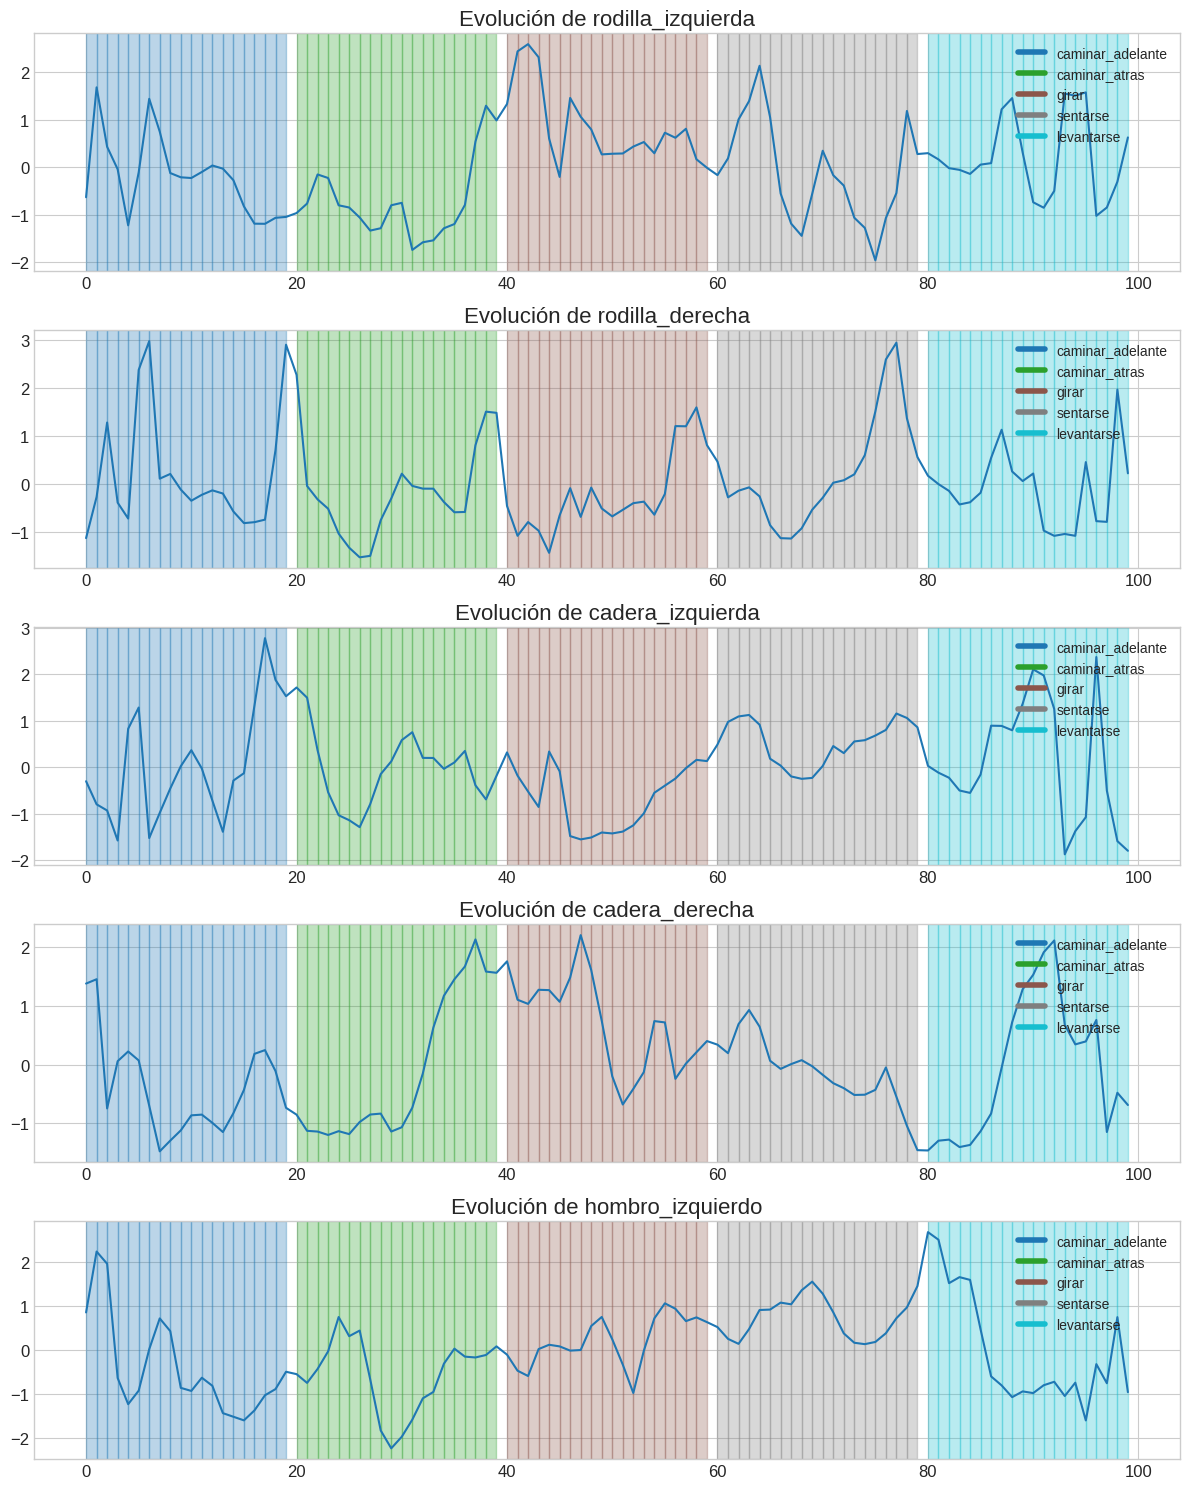

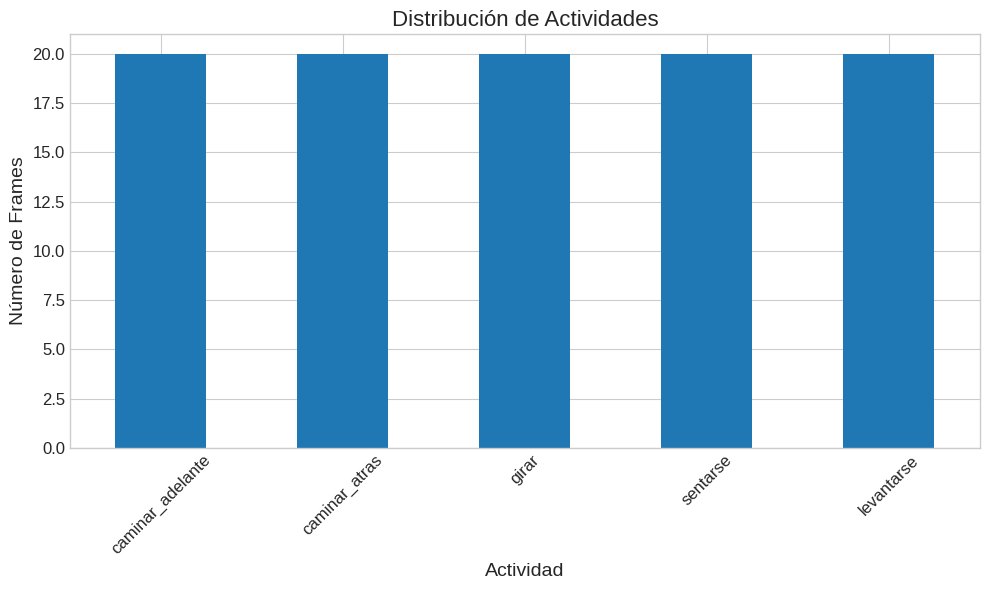

<Figure size 1200x800 with 0 Axes>

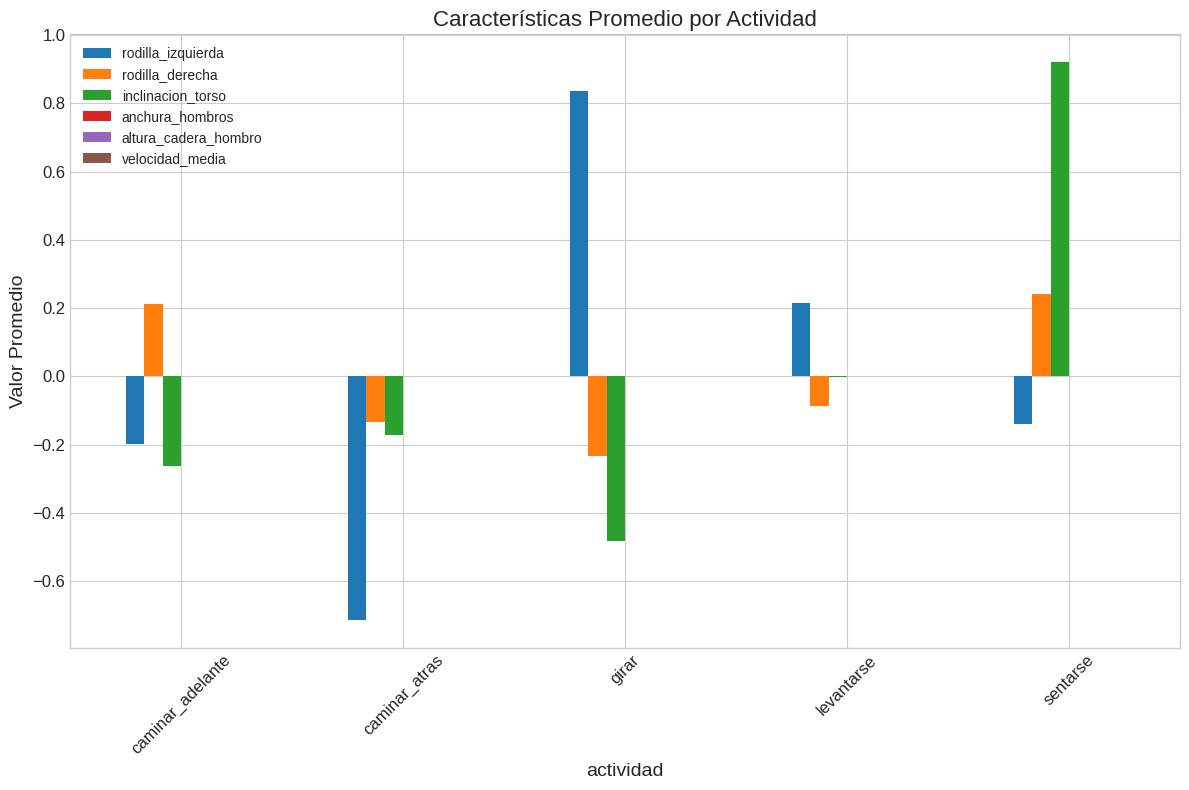

In [21]:
# Uso del Pipeline de Preprocesamiento
try:
    # Crear instancia del pipeline con configuración personalizada
    pipeline = PreprocessingPipeline(
        normalization_methods=['hip_center', 'body_scale', 'orientation'],
        filtering_methods=['interpolate', 'median', 'moving_average'],
        window_size=15,  # Ventana de 15 frames para características temporales (0.5 segundos a 30fps)
        feature_scaling=True  # Aplicar escalado de características
    )

    # Procesar datos de un participante específico (o usar datos simulados si no hay reales)
    participant_id = "01"  # Cambiar al ID de participante real si está disponible
    view = "frontal"  # 'frontal' o 'lateral'

    # Procesar datos
    processed_data = pipeline.process_participant_data(participant_id, view)

    # Mostrar información sobre los datos procesados
    print(f"\nDatos procesados para participante {participant_id}, vista {view}:")
    print(f"Número de frames: {len(processed_data)}")
    print(f"Características extraídas: {processed_data.shape[1]}")
    print(f"Columnas: {processed_data.columns.tolist()[:10]}...")

    # Visualizar resultados
    pipeline.visualize_processing_results(processed_data, n_features=5, show_activity_distribution=True)
except Exception as e:
    print(f"Error al ejecutar el pipeline: {e}")

In [22]:
# Procesamiento de Múltiples Participantes
try:
    # Definir lista de participantes a procesar
    # En un caso real, esto podría obtenerse escaneando el directorio de datos
    participant_ids = ["01", "02", "03"]  # Ajustar según la disponibilidad de datos

    # Procesar todos los participantes y ambas vistas
    all_processed_data = pipeline.process_all_participants(
        participant_ids=participant_ids,
        views=["frontal", "lateral"]
    )

    # Mostrar resumen de los datos procesados
    print("\nResumen de datos procesados:")
    for key, df in all_processed_data.items():
        if not df.empty:
            n_activities = df['actividad'].nunique() if 'actividad' in df.columns else 0
            print(f"{key}: {len(df)} frames, {n_activities} actividades")

    # Guardar datos procesados
    pipeline.save_processed_data(all_processed_data)

    # Generar informe de preprocesamiento
    pipeline.generate_processing_report(all_processed_data)
except Exception as e:
    print(f"Error al procesar múltiples participantes: {e}")

Archivo no encontrado: /content/drive/MyDrive/ICESI/IA1/Proyecto_Anotacion_Video/dataset/participante_01/landmarks/frontal.csv
Generando datos de prueba...
Archivo de etiquetas no encontrado: /content/drive/MyDrive/ICESI/IA1/Proyecto_Anotacion_Video/dataset/participante_01/etiquetas/frontal.json
Generando etiquetas de prueba...
Aplicando normalización de landmarks...
Aplicando filtros: interpolate, median, moving_average...
Extrayendo características...
Procesamiento completado para participante 01, vista frontal
Estadísticas: {'frames_procesados': 200, 'frames_con_landmarks_completos': 200, 'frames_con_oclusiones': 0, 'tiempo_procesamiento': 0.7641165256500244}
Archivo no encontrado: /content/drive/MyDrive/ICESI/IA1/Proyecto_Anotacion_Video/dataset/participante_01/landmarks/lateral.csv
Generando datos de prueba...
Archivo de etiquetas no encontrado: /content/drive/MyDrive/ICESI/IA1/Proyecto_Anotacion_Video/dataset/participante_01/etiquetas/lateral.json
Generando etiquetas de prueba...

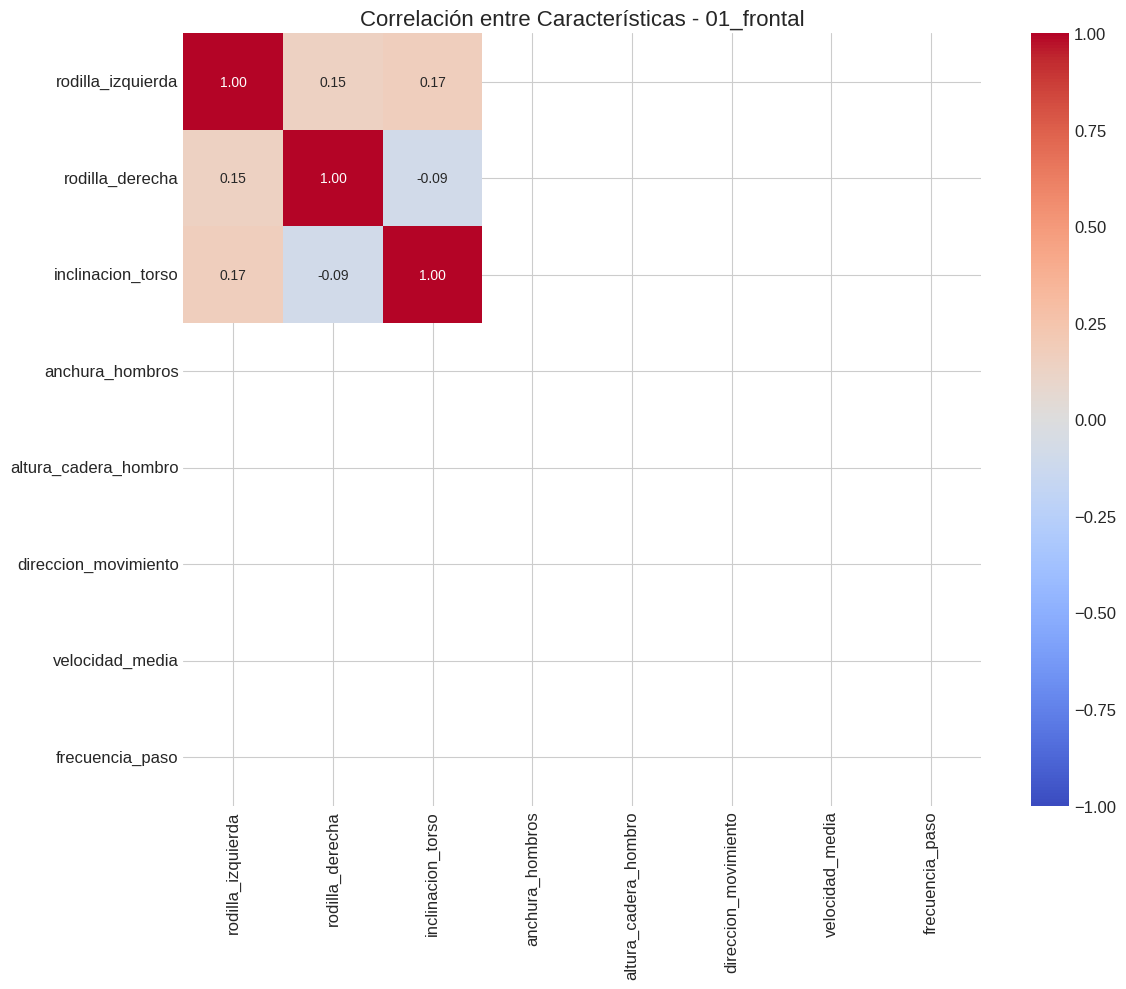

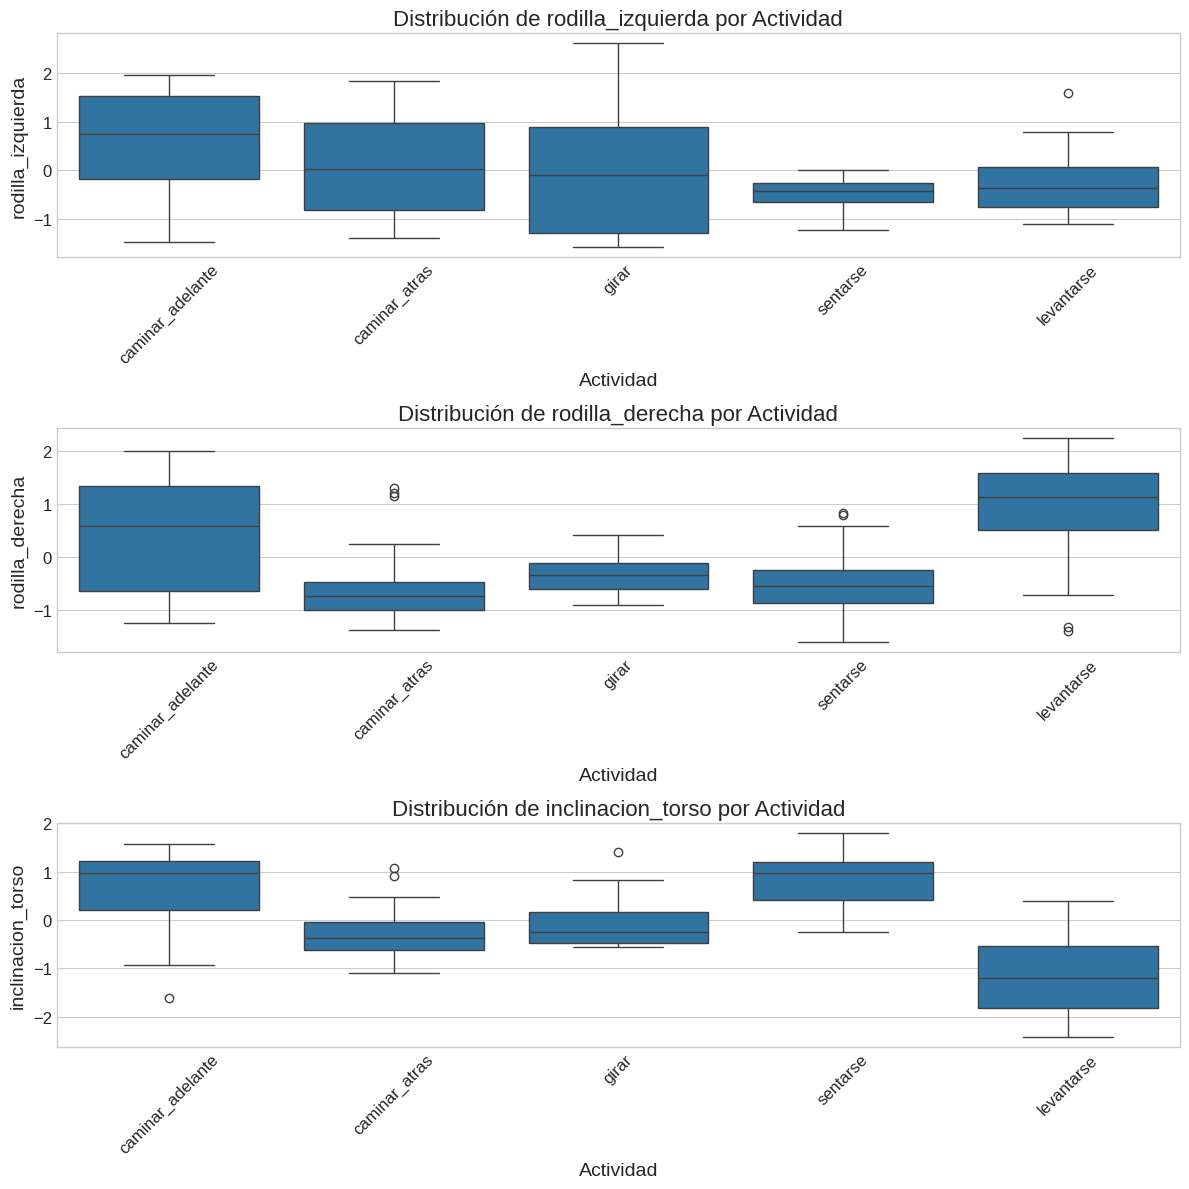

In [23]:
# Análisis Exploratorio de Características
try:
    # Seleccionar un conjunto de datos procesados para análisis
    if 'all_processed_data' in locals() and len(all_processed_data) > 0:
        analysis_key = list(all_processed_data.keys())[0]
        analysis_data = all_processed_data[analysis_key]

        if 'actividad' in analysis_data.columns:
            # 1. Análisis de correlación entre características
            # Seleccionar características numéricas más relevantes
            features_of_interest = [
                'rodilla_izquierda', 'rodilla_derecha', 'inclinacion_torso',
                'anchura_hombros', 'altura_cadera_hombro', 'direccion_movimiento',
                'velocidad_media', 'frecuencia_paso'
            ]

            # Filtrar solo características disponibles
            available_features = [f for f in features_of_interest if f in analysis_data.columns]

            if available_features:
                # Matriz de correlación
                correlation = analysis_data[available_features].corr()

                # Visualizar correlaciones
                plt.figure(figsize=(12, 10))
                sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
                plt.title(f'Correlación entre Características - {analysis_key}')
                plt.tight_layout()
                plt.show()

                # 2. Distribución de características por actividad
                # Seleccionar 3 características más discriminativas
                top_features = available_features[:min(3, len(available_features))]

                fig, axes = plt.subplots(len(top_features), 1, figsize=(12, 4 * len(top_features)))
                if len(top_features) == 1:
                    axes = [axes]

                for i, feature in enumerate(top_features):
                    sns.boxplot(x='actividad', y=feature, data=analysis_data, ax=axes[i])
                    axes[i].set_title(f'Distribución de {feature} por Actividad')
                    axes[i].set_xlabel('Actividad')
                    axes[i].set_ylabel(feature)
                    axes[i].tick_params(axis='x', rotation=45)

                plt.tight_layout()
                plt.show()
            else:
                print("No se encontraron características de interés en los datos procesados.")
        else:
            print("No se encontraron etiquetas de actividad en los datos procesados.")
    else:
        print("No hay datos procesados disponibles para análisis.")
except Exception as e:
    print(f"Error en análisis de características: {e}")

#Modelos

In [32]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


class ActivityClassifier:
    """
    Clase para entrenar y evaluar modelos de clasificación de actividades físicas
    basados en características extraídas de landmarks corporales.
    """
    def __init__(self, models_to_try=None):
        """
        Inicializa el clasificador con los modelos especificados.
        """
        self.models = {}
        self.best_models = {}
        self.results = {}
        # Definir modelos a probar si no se especifican
        if models_to_try is None:
            self.models_to_try = ['svm', 'random_forest', 'xgboost']
        else:
            self.models_to_try = models_to_try

    def prepare_data(self, features_df, test_size=0.2, random_state=42):
        """
        Prepara los datos para entrenamiento y prueba.
        """
        # Seleccionar características y etiquetas
        if 'actividad' not in features_df.columns:
            raise ValueError("La columna 'actividad' no está presente en los datos")

        # Eliminar columnas que no son características
        exclude_cols = ['frame_index', 'actividad', 'velocidad', 'vista']
        feature_cols = [col for col in features_df.columns if col not in exclude_cols]

        # Verificar que hay características disponibles
        if len(feature_cols) == 0:
            raise ValueError("No hay características disponibles para entrenamiento")

        # Separar características y etiquetas
        X = features_df[feature_cols].fillna(0)  # Reemplazar NaN con 0
        y = features_df['actividad']

        # Codificar etiquetas
        self.label_encoder = LabelEncoder()
        y_encoded = self.label_encoder.fit_transform(y)

        # Dividir en conjuntos de entrenamiento y prueba
        X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
            X, y_encoded, test_size=test_size, random_state=random_state, stratify=y_encoded
        )

        # Guardar datos originales para evaluación
        _, _, _, self.y_test_original = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )

        # Guardar datos preparados
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train_encoded
        self.y_test = y_test_encoded
        self.feature_names = feature_cols

        print(f"Datos preparados: {X_train.shape[0]} muestras de entrenamiento, {X_test.shape[0]} muestras de prueba")
        unique_labels, counts = np.unique(self.y_train, return_counts=True)
        print(f"Distribución de clases codificadas en entrenamiento: {dict(zip(self.label_encoder.inverse_transform(unique_labels), counts))}")

        return self.X_train, self.X_test, self.y_train, self.y_test

    def train_and_tune_models(self):
        """
        Entrena y ajusta hiperparámetros para los modelos seleccionados.
        """
        if not hasattr(self, 'X_train'):
            raise ValueError("Primero debe preparar los datos con prepare_data()")

        # Configurar parámetros para cada modelo
        param_grids = {
            'svm': {
                'C': [0.1, 1, 10, 100],
                'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
                'kernel': ['rbf', 'linear']
            },
            'random_forest': {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            },
            'xgboost': {
                'n_estimators': [50, 100, 200],
                'max_depth': [3, 6, 9],
                'learning_rate': [0.01, 0.1, 0.2],
                'subsample': [0.8, 1.0],
                'colsample_bytree': [0.8, 1.0],
                # Wrap single values in a list
                'objective': ['multi:softmax'], # FIX: Wrap in a list
                'num_class': [len(self.label_encoder.classes_)] # FIX: Wrap in a list
            }
        }

        # Crear y ajustar cada modelo
        for model_name in self.models_to_try:
            print(f"\nEntrenando y ajustando modelo: {model_name}")

            if model_name == 'svm':
                base_model = SVC(probability=True)
                param_grid = param_grids['svm']
            elif model_name == 'random_forest':
                base_model = RandomForestClassifier(random_state=42)
                param_grid = param_grids['random_forest']
            elif model_name == 'xgboost':
                base_model = xgb.XGBClassifier(
                    random_state=42,
                    use_label_encoder=False,
                    eval_metric='mlogloss'
                )
                param_grid = param_grids['xgboost']
            else:
                print(f"Modelo {model_name} no reconocido. Omitiendo.")
                continue

            # Reducir el número de combinaciones para modelos grandes
            if model_name in ['random_forest', 'xgboost']:
                param_grid_sampled = {}
                for k, v in param_grid.items():
                    if isinstance(v, list):
                        param_grid_sampled[k] = v[:min(len(v), 2)]
                    else:
                        param_grid_sampled[k] = v
                param_grid = param_grid_sampled


            # Usar validación cruzada para encontrar mejores hiperparámetros
            grid_search = GridSearchCV(
                base_model, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1
            )
            grid_search.fit(self.X_train, self.y_train)

            # Guardar el mejor modelo y sus resultados
            self.best_models[model_name] = grid_search.best_estimator_
            self.results[model_name] = {
                'best_params': grid_search.best_params_,
                'best_score': grid_search.best_score_,
                'cv_results': grid_search.cv_results_
            }
            print(f"Mejores parámetros para {model_name}: {grid_search.best_params_}")
            print(f"Mejor F1 ponderado (CV): {grid_search.best_score_:.4f}")

    def evaluate_models(self):
        """
        Evalúa los modelos entrenados en el conjunto de prueba.
        """
        if not hasattr(self, 'best_models') or len(self.best_models) == 0:
            raise ValueError("Primero debe entrenar los modelos con train_and_tune_models()")

        evaluation_results = {}
        for model_name, model in self.best_models.items():
            print(f"\nEvaluando modelo: {model_name}")

            # Predecir en conjunto de prueba
            y_pred_encoded = model.predict(self.X_test)
            y_pred = self.label_encoder.inverse_transform(y_pred_encoded)
            y_true = self.y_test_original

            # Calcular métricas
            report = classification_report(y_true, y_pred, output_dict=True)
            conf_matrix = confusion_matrix(y_true, y_pred)

            # Guardar resultados
            evaluation_results[model_name] = {
                'classification_report': report,
                'confusion_matrix': conf_matrix,
                'accuracy': report['accuracy'],
                'weighted_precision': report['weighted avg']['precision'],
                'weighted_recall': report['weighted avg']['recall'],
                'weighted_f1': report['weighted avg']['f1-score']
            }

            # Mostrar resultados
            print(f"Exactitud: {report['accuracy']:.4f}")
            print(f"Precisión ponderada: {report['weighted avg']['precision']:.4f}")
            print(f"Recall ponderado: {report['weighted avg']['recall']:.4f}")
            print(f"F1 ponderado: {report['weighted avg']['f1-score']:.4f}")

            # Visualizar matriz de confusión
            plt.figure(figsize=(10, 8))
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                        xticklabels=self.label_encoder.classes_,
                        yticklabels=self.label_encoder.classes_)
            plt.xlabel('Predicción')
            plt.ylabel('Valor real')
            plt.title(f'Matriz de confusión - {model_name}')
            plt.tight_layout()
            plt.show()

        self.evaluation_results = evaluation_results
        return evaluation_results

    def plot_feature_importance(self):
        """
        Visualiza la importancia de características para modelos que lo soportan.
        """
        models_with_importance = ['random_forest', 'xgboost']
        for model_name in models_with_importance:
            if model_name in self.best_models:
                model = self.best_models[model_name]

                # Extraer importancia de características
                if hasattr(model, 'feature_importances_'):
                    importances = model.feature_importances_
                elif hasattr(model, 'coef_'):
                    # For linear models like SVM (with linear kernel)
                    importances = np.abs(model.coef_[0]) # Assuming binary or multi-class with one-vs-rest
                else:
                    print(f"Modelo {model_name} no soporta visualización de importancia de características.")
                    continue


                # Crear DataFrame para visualización
                feature_importance = pd.DataFrame({
                    'feature': self.feature_names,
                    'importance': importances
                })

                # Ordenar por importancia
                feature_importance = feature_importance.sort_values('importance', ascending=False)

                # Visualizar
                plt.figure(figsize=(12, 8))
                sns.barplot(x='importance', y='feature', data=feature_importance)
                plt.title(f'Importancia de características - {model_name}')
                plt.tight_layout()
                plt.show()

    def compare_models(self):
        """
        Compara el rendimiento de los modelos entrenados.
        """
        if not hasattr(self, 'evaluation_results'):
            raise ValueError("Primero debe evaluar los modelos con evaluate_models()")

        # Extraer métricas para comparación
        metrics = ['accuracy', 'weighted_precision', 'weighted_recall', 'weighted_f1']
        model_names = list(self.evaluation_results.keys())
        comparison_data = []

        for model_name in model_names:
            row = {'modelo': model_name}
            for metric in metrics:
                row[metric] = self.evaluation_results[model_name][metric]
            comparison_data.append(row)

        comparison_df = pd.DataFrame(comparison_data)

        # Visualizar comparación
        plt.figure(figsize=(14, 8))
        comparison_melted = pd.melt(comparison_df, id_vars=['modelo'],
                                   value_vars=metrics,
                                   var_name='métrica', value_name='valor')
        sns.barplot(x='modelo', y='valor', hue='métrica', data=comparison_melted)
        plt.title('Comparación de métricas entre modelos')
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        return comparison_df

Archivo no encontrado: /content/drive/MyDrive/ICESI/IA1/Proyecto_Anotacion_Video/dataset/participante_01/landmarks/frontal.csv
Generando datos de prueba...
Archivo de etiquetas no encontrado: /content/drive/MyDrive/ICESI/IA1/Proyecto_Anotacion_Video/dataset/participante_01/etiquetas/frontal.json
Generando etiquetas de prueba...
Aplicando normalización de landmarks...
Aplicando filtros: interpolate, median, moving_average...
Extrayendo características...
Procesamiento completado para participante 01, vista frontal
Estadísticas: {'frames_procesados': 100, 'frames_con_landmarks_completos': 100, 'frames_con_oclusiones': 0, 'tiempo_procesamiento': 0.6590204238891602}
Datos preparados: 80 muestras de entrenamiento, 20 muestras de prueba
Distribución de clases codificadas en entrenamiento: {'caminar_adelante': np.int64(16), 'caminar_atras': np.int64(16), 'girar': np.int64(16), 'levantarse': np.int64(16), 'sentarse': np.int64(16)}

Entrenando y ajustando modelo: svm
Fitting 5 folds for each of

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:49:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores parámetros para xgboost: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'num_class': 5, 'objective': 'multi:softmax', 'subsample': 1.0}
Mejor F1 ponderado (CV): 0.7700

Evaluando modelo: svm
Exactitud: 0.6500
Precisión ponderada: 0.6200
Recall ponderado: 0.6500
F1 ponderado: 0.6089


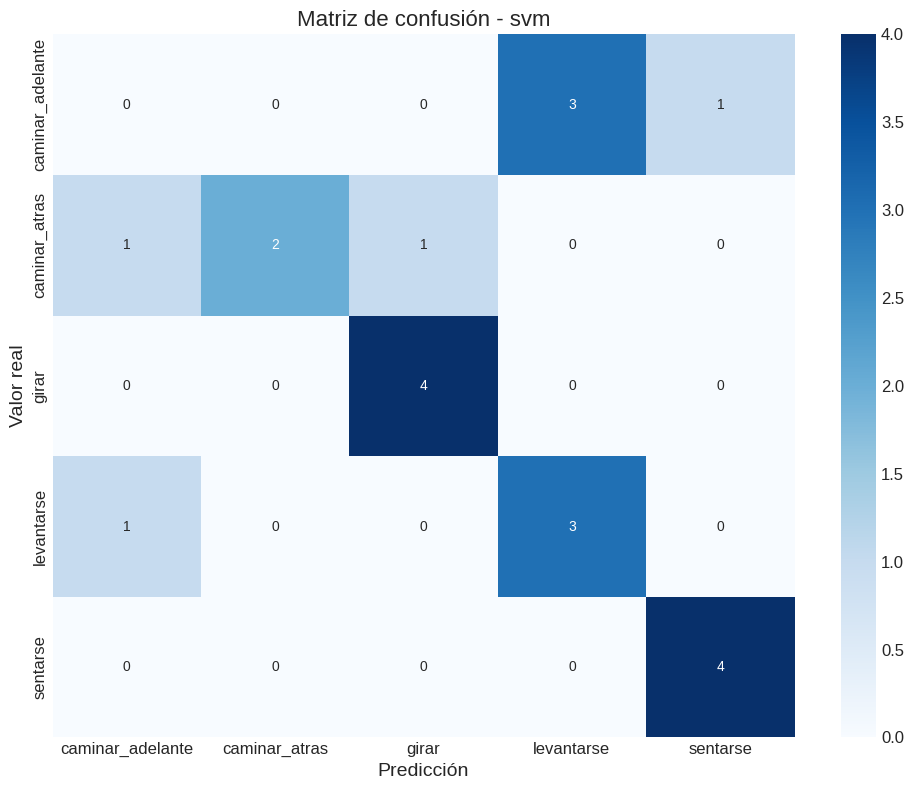


Evaluando modelo: random_forest
Exactitud: 0.7000
Precisión ponderada: 0.6933
Recall ponderado: 0.7000
F1 ponderado: 0.6806


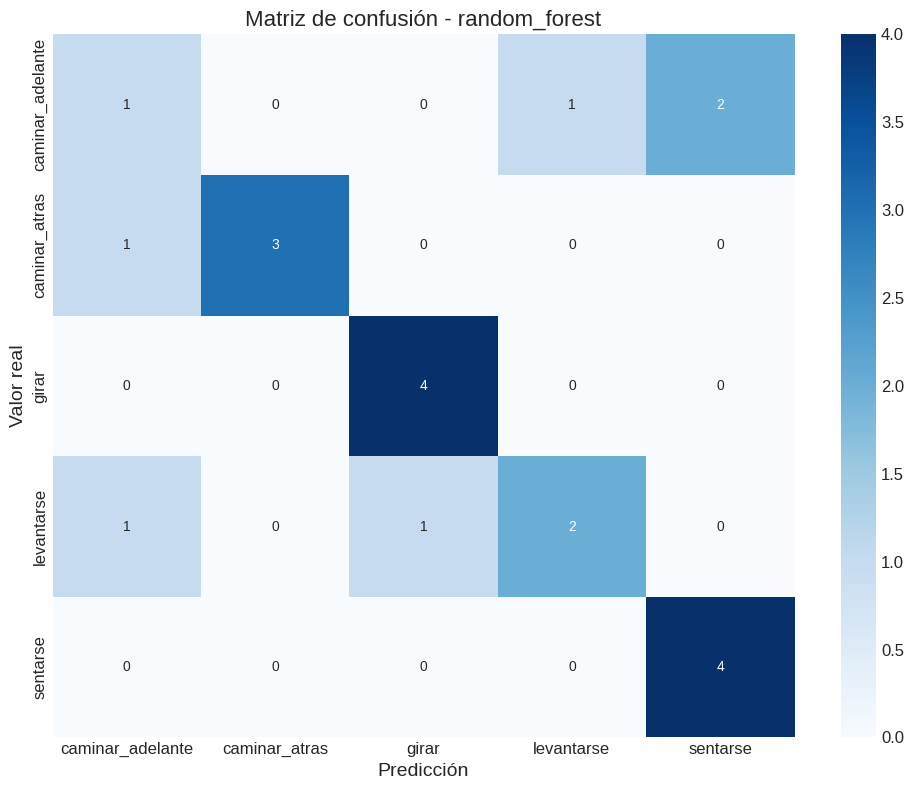


Evaluando modelo: xgboost
Exactitud: 0.8000
Precisión ponderada: 0.7933
Recall ponderado: 0.8000
F1 ponderado: 0.7759


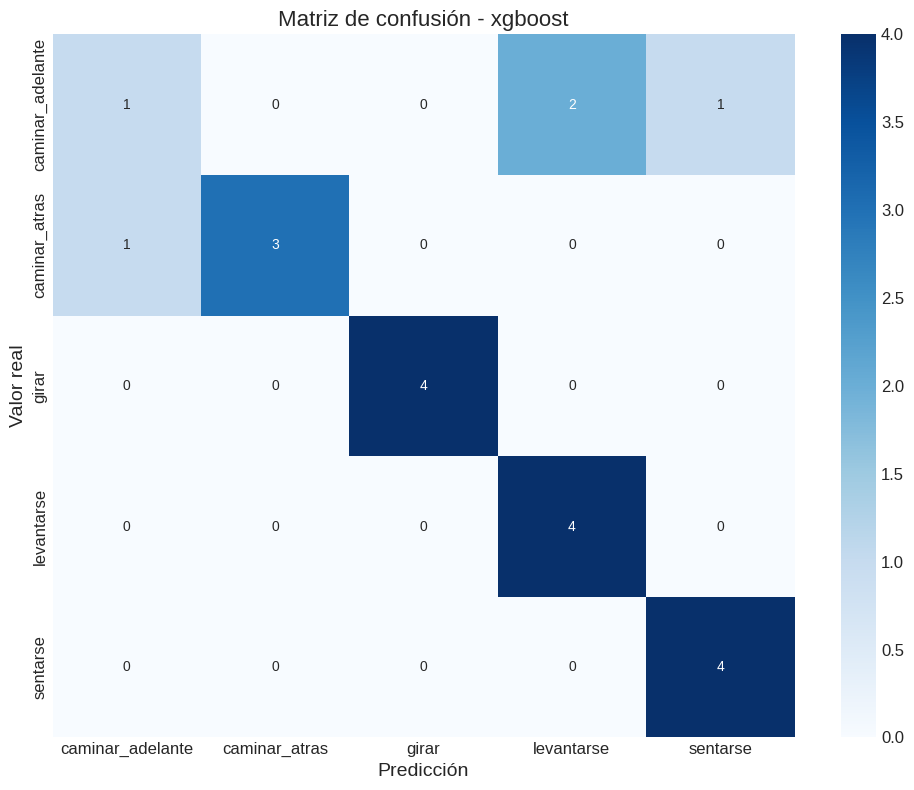

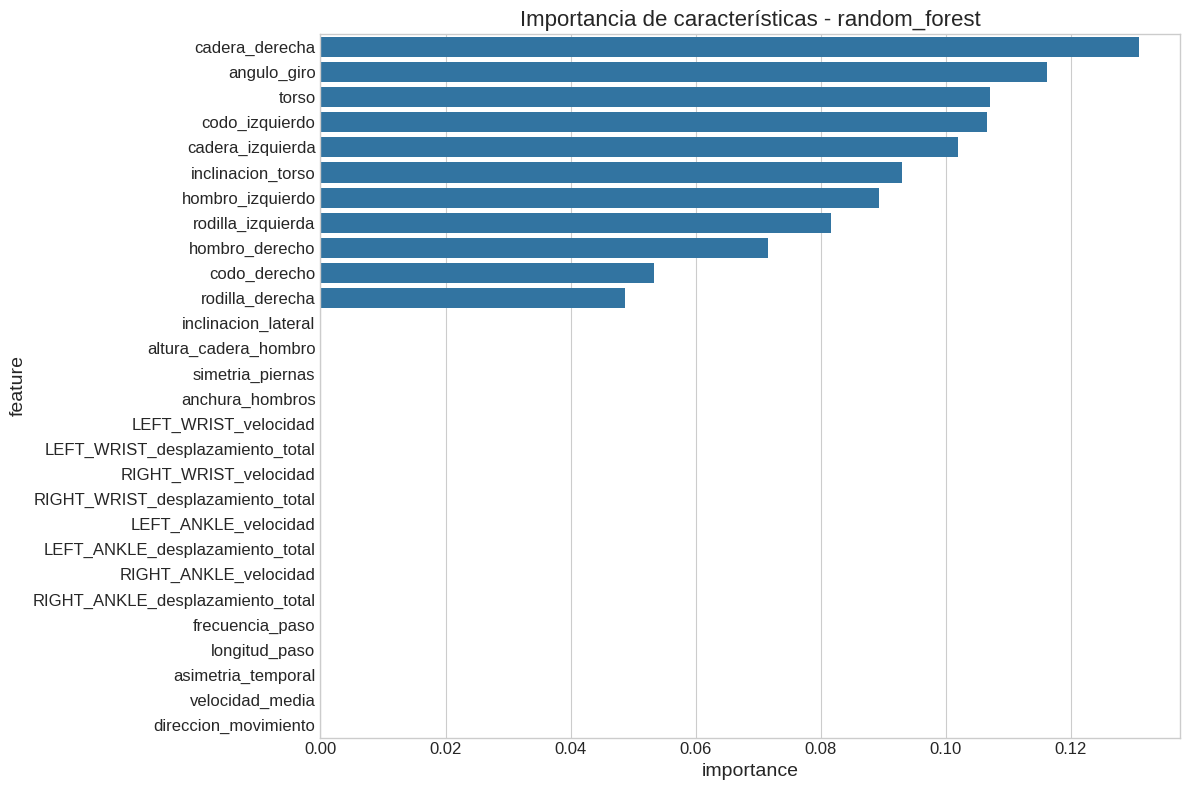

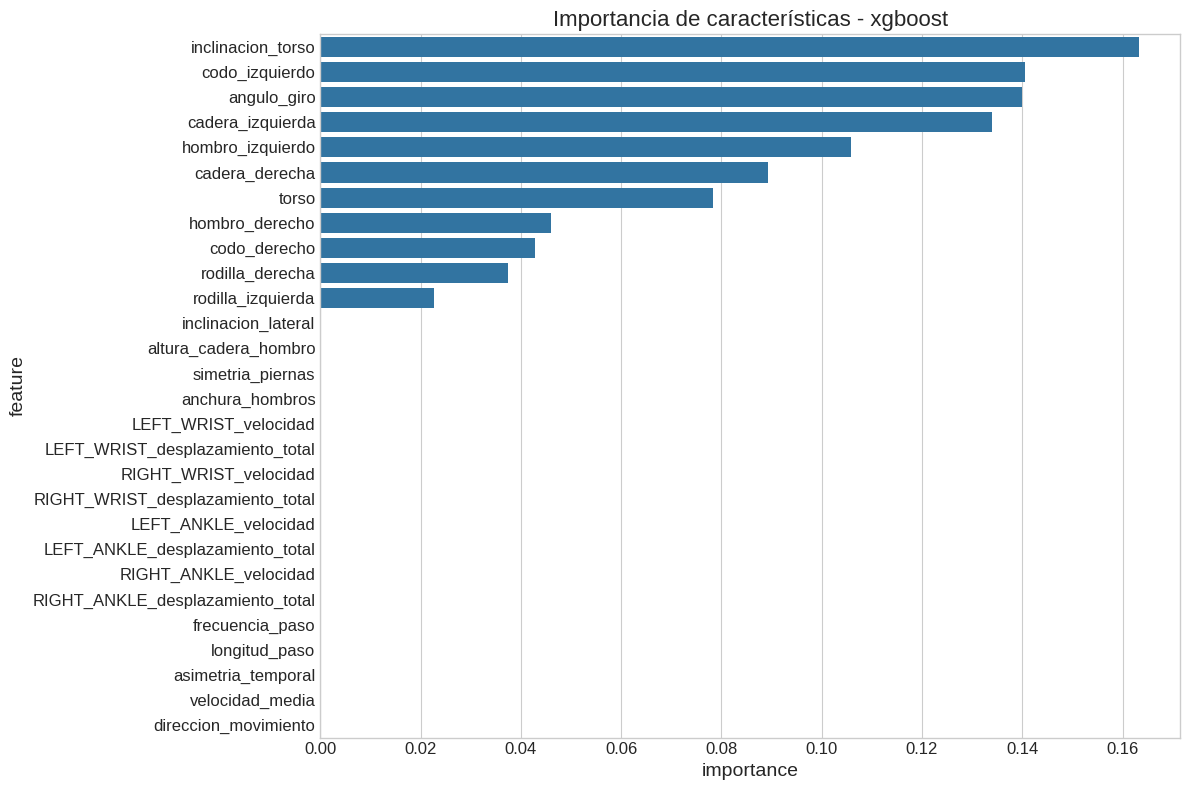

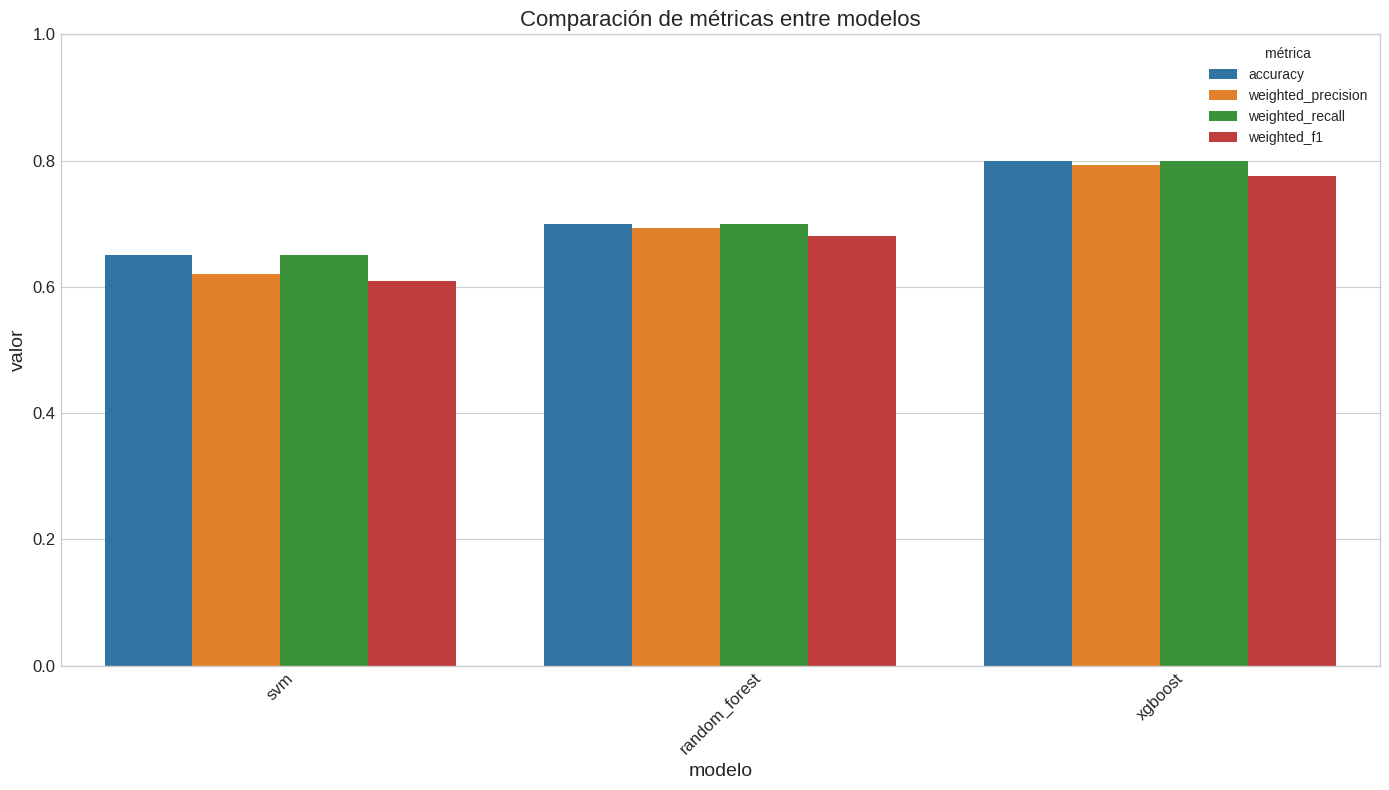

In [33]:
# Ejemplo de uso del clasificador
def train_activity_models(processed_data):
    """
    Entrena modelos para clasificar actividades basadas en las características extraídas.

    Args:
        processed_data: DataFrame con características y etiquetas de actividad

    Returns:
        Clasificador entrenado
    """
    # Crear instancia del clasificador
    classifier = ActivityClassifier(['svm', 'random_forest', 'xgboost'])

    # Preparar datos
    classifier.prepare_data(processed_data)

    # Entrenar y ajustar modelos
    classifier.train_and_tune_models()

    # Evaluar modelos
    classifier.evaluate_models()

    # Visualizar importancia de características
    classifier.plot_feature_importance()

    # Comparar rendimiento de modelos
    comparison = classifier.compare_models()

    return classifier

# Para usar con los datos de ejemplo
pipeline = PreprocessingPipeline()
participant_id = "01"  # Ajustar según disponibilidad
processed_data = pipeline.process_participant_data(participant_id, "frontal")

# Entrenar modelos
activity_classifier = train_activity_models(processed_data)